In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia_all = Table.read('../data/gaia_slim_xsdss.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia_all))

Total number of Gaia quasars: 6649162


In [4]:
fn_gaia = f'../data/gaia_clean.fits'
tab_gaia = Table.read(fn_gaia, format='fits')

In [70]:
G_max_spz = 20.5
#spz_tag = '_scaledNOqsoc'
spz_tag = ''
fn_spz = f'../data/redshifts_spz_kNN_G{G_max_spz}{spz_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [6]:
i_has_sdss_redshift = np.isfinite(tab_gaia['sdss_Z'])
np.sum(i_has_sdss_redshift)

330736

In [7]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

In [8]:
i_has_sdss_redshift = np.isfinite(tab_spz['sdss_Z'])
z_sdss = tab_spz['sdss_Z'][i_has_sdss_redshift]
z_spz = tab_spz['redshift_spz'][i_has_sdss_redshift]
z_qsoc = tab_spz['redshift_qsoc'][i_has_sdss_redshift]

dz_spz = (z_spz-z_sdss)
dz_qsoc = (z_qsoc-z_sdss)

dz1pz_spz = (z_spz-z_sdss)/(1+z_sdss)
dz1pz_qsoc = (z_qsoc-z_sdss)/(1+z_sdss)

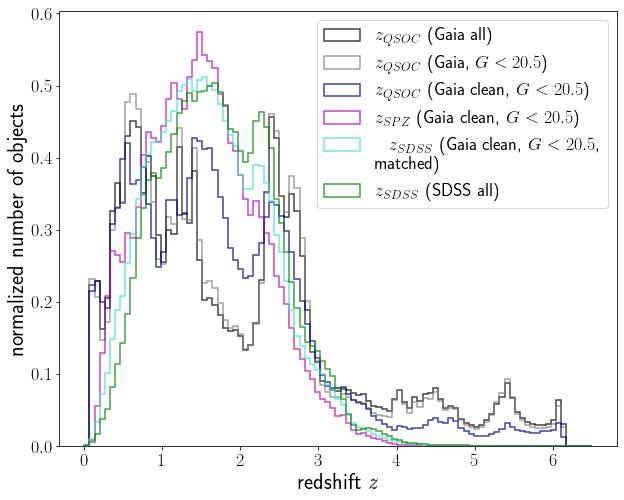

In [9]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

i_makeGcut = tab_gaia_all['phot_g_mean_mag'] < 20.5

plt.figure(figsize=(10,8))
_ = plt.hist(tab_gaia_all['redshift_qsoc'], bins=z_bins, alpha=alpha, color='k', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia all)')
_ = plt.hist(tab_gaia_all['redshift_qsoc'][i_makeGcut], bins=z_bins, alpha=alpha, color='grey', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia, $G<20.5$)')
_ = plt.hist(tab_spz['redshift_qsoc'], bins=z_bins, alpha=alpha, color='navy', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia clean, $G<20.5$)')
_ = plt.hist(tab_spz['redshift_spz'], bins=z_bins, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{SPZ}$ (Gaia clean, $G<20.5$)')
_ = plt.hist(z_sdss, bins=z_bins, alpha=alpha, color='turquoise', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (Gaia clean, $G<20.5$,\\matched)')
_ = plt.hist(tab_sdss['Z'], bins=z_bins, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (SDSS all)')
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

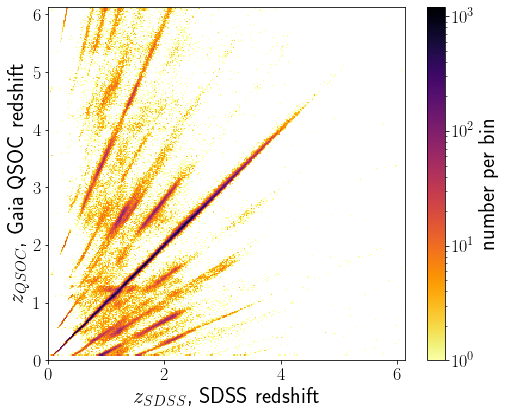

In [10]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_qsoc, bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
# h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
#              norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

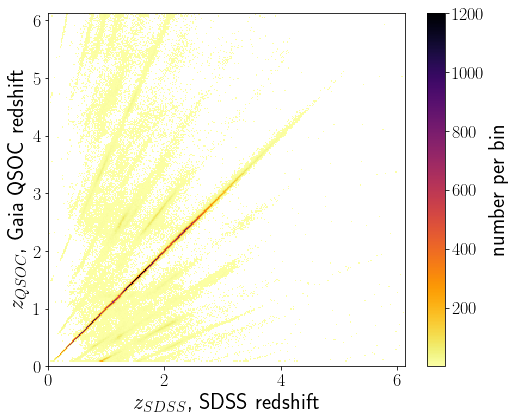

In [38]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_qsoc, bins=z_bins, cmin=1, cmap='inferno_r',
               vmax=1200)
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

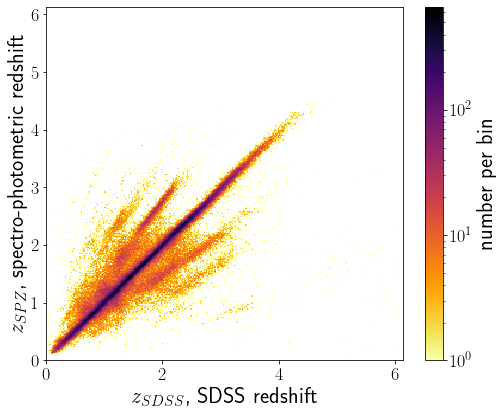

In [12]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_spz, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

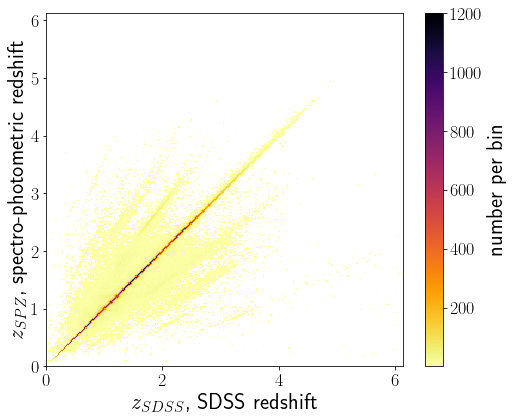

In [39]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_spz, bins=z_bins, cmin=1, cmap='inferno_r',
              vmax=1200)
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [14]:
def get_fraction_within_threshold(diffs, threshold):
    return np.sum(np.abs(diffs) < threshold) / len(diffs)

In [49]:
z_threshs = [0.02, 0.05, 0.1, 0.2]
print("Number of test objects: ", len(z_sdss))
for z_thresh in z_threshs:
    frac_recovered = get_fraction_within_threshold(dz_spz, z_thresh)
    frac_recovered_baseline = get_fraction_within_threshold(dz_qsoc, z_thresh)
    print(rf"Fraction recovered with dz<{z_thresh}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260119
Fraction recovered with dz<0.02: 0.340
(Baseline: 0.605)
Fraction recovered with dz<0.05: 0.634
(Baseline: 0.703)
Fraction recovered with dz<0.1: 0.775
(Baseline: 0.719)
Fraction recovered with dz<0.2: 0.838
(Baseline: 0.726)


In [50]:
print("Number of test objects: ", len(z_sdss))
for z_thresh in z_threshs:
    frac_recovered = get_fraction_within_threshold(dz1pz_spz, z_thresh)
    frac_recovered_baseline = get_fraction_within_threshold(dz1pz_qsoc, z_thresh)
    print(rf"Fraction recovered with dz(1+z)<{z_thresh}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260119
Fraction recovered with dz(1+z)<0.02: 0.631
(Baseline: 0.707)
Fraction recovered with dz(1+z)<0.05: 0.791
(Baseline: 0.720)
Fraction recovered with dz(1+z)<0.1: 0.846
(Baseline: 0.727)
Fraction recovered with dz(1+z)<0.2: 0.914
(Baseline: 0.746)


# G<20 only

In [17]:
G_max = 20
idx_G = tab_spz['phot_g_mean_mag'][i_has_sdss_redshift] < G_max

In [18]:
z_threshs = [0.1, 0.2]
print("Number of test objects: ", len(z_sdss))
for z_thresh in z_threshs:
    frac_recovered = get_fraction_within_threshold(dz_spz[idx_G], z_thresh)
    frac_recovered_baseline = get_fraction_within_threshold(dz_qsoc[idx_G], z_thresh)
    print(rf"Fraction recovered with dz<{z_thresh}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260119
Fraction recovered with dz<0.1: 0.869
(Baseline: 0.818)
Fraction recovered with dz<0.2: 0.909
(Baseline: 0.823)


In [19]:
print("Number of test objects: ", len(z_sdss))
for z_thresh in z_threshs:
    frac_recovered = get_fraction_within_threshold(dz1pz_spz[idx_G], z_thresh)
    frac_recovered_baseline = get_fraction_within_threshold(dz1pz_qsoc[idx_G], z_thresh)
    print(rf"Fraction recovered with dz(1+z)<{z_thresh}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260119
Fraction recovered with dz(1+z)<0.1: 0.912
(Baseline: 0.823)
Fraction recovered with dz(1+z)<0.2: 0.947
(Baseline: 0.832)


## Cumulative dist

Text(0, 0.5, 'number per bin')

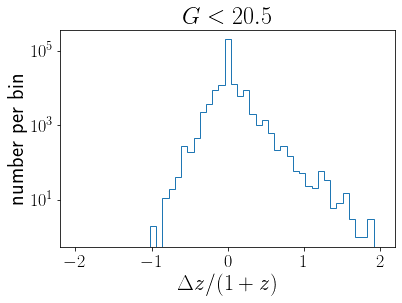

In [20]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(dz1pz_spz, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z/(1+z)$')
plt.ylabel('number per bin')

(0.0, 1.0)

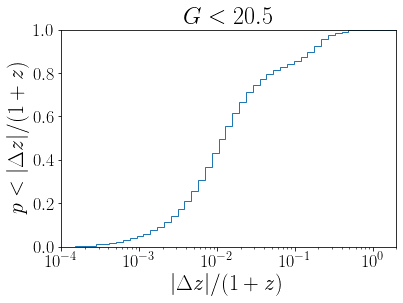

In [21]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(abs(dz1pz_spz), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|/(1+z)$')
plt.ylabel(r'$p < |\Delta z|/(1+z)$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, 'number per bin')

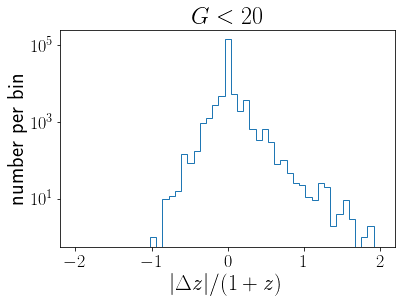

In [22]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(dz1pz_spz[idx_G], bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$|\Delta z|/(1+z)$')
plt.ylabel('number per bin')

(0.0, 1.0)

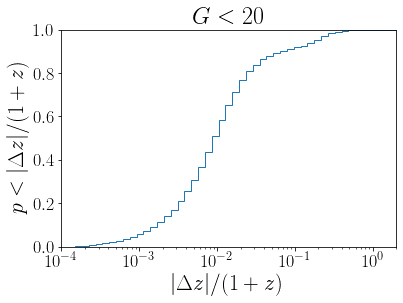

In [23]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(dz1pz_spz[idx_G]), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|/(1+z)$')
plt.ylabel(r'$p < |\Delta z|/(1+z)$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

# precision

In [24]:
dz1pz_bins = np.linspace(np.min(dz1pz_qsoc), np.max(dz1pz_qsoc), 80)

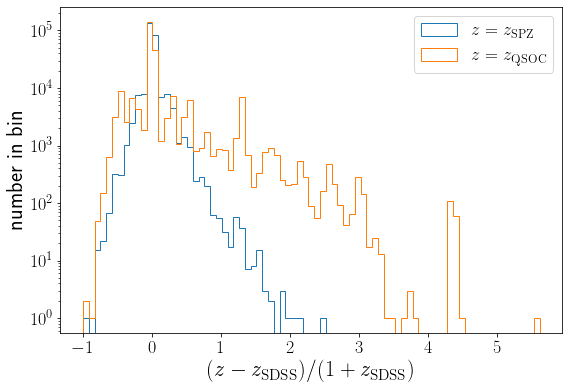

In [25]:
plt.figure(figsize=(9,6))
plt.hist(dz1pz_spz, bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz1pz_qsoc, bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
plt.yscale('log')

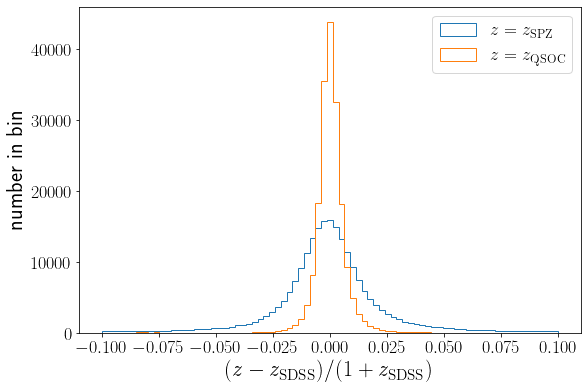

In [26]:
plt.figure(figsize=(9,6))
dz1pz_bins_near_zero = np.linspace(-0.1, 0.1, 80)
plt.hist(dz1pz_spz, bins=dz1pz_bins_near_zero, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz1pz_qsoc, bins=dz1pz_bins_near_zero, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()

Text(0, 0.5, 'number in bin')

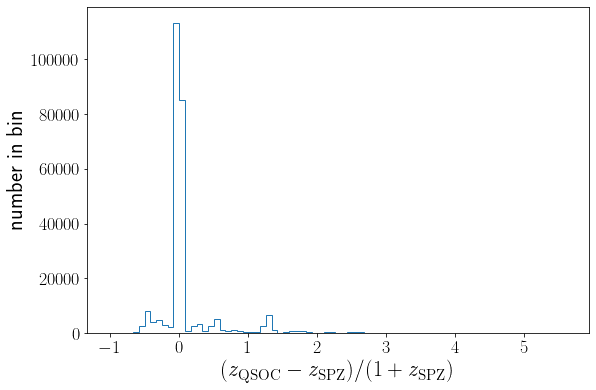

In [27]:
dz1pz_qsoc_spz = (z_qsoc-z_spz)/(1+z_spz)

plt.figure(figsize=(9,6))
plt.hist(dz1pz_qsoc_spz, bins=dz1pz_bins, histtype='step')
plt.xlabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SPZ})/(1 + z_\mathrm{SPZ})$')
plt.ylabel('number in bin')
#plt.yscale('log')

In [28]:
dz1pz_thresh = 0.1
i_qsoc_spz_agree = np.abs(dz1pz_qsoc_spz) < dz1pz_thresh
n_agree = np.sum(i_qsoc_spz_agree)
f_agree = n_agree / len(dz1pz_qsoc_spz)
print(f"{f_agree:.3f} of QSOC and SPZ redshifts agree to dz/(1+z)<{dz1pz_thresh}")
print(len(i_qsoc_spz_agree), len(dz1pz_qsoc_spz))

0.767 of QSOC and SPZ redshifts agree to dz/(1+z)<0.1
260119 260119


But if they agree, is QSOC right?

In [29]:
print(len(dz1pz_qsoc[i_qsoc_spz_agree]))

i_qsocright_qsocspzagree = np.abs(dz1pz_qsoc[i_qsoc_spz_agree]) < dz1pz_thresh
print(f"Where QSOC and SPZ redshifts agree, QSOC is correct for {np.sum(i_qsocright_qsocspzagree)/len(dz_qsoc[i_qsoc_spz_agree]):.3f}")

i_qsocright_qsocspzdisagree = np.abs(dz1pz_qsoc[~i_qsoc_spz_agree]) < dz1pz_thresh
print(f"Where they don't, QSOC is correct for {np.sum(i_qsocright_qsocspzdisagree)/len(dz_qsoc[~i_qsoc_spz_agree]):.3f}")

i_spzright_qsocspzdisagree = np.abs(dz1pz_spz[~i_qsoc_spz_agree]) < dz1pz_thresh
print(f"Where they don't, SPZ is correct for {np.sum(i_spzright_qsocspzdisagree)/len(dz_spz[~i_qsoc_spz_agree]):.3f}")

199470
Where QSOC and SPZ redshifts agree, QSOC is correct for 0.919
Where they don't, QSOC is correct for 0.096
Where they don't, SPZ is correct for 0.600


So let's take QSOC where they agree for precision, SPZ elsewhere for accuracy:

In [30]:
z_spzqsoc = z_spz
z_spzqsoc[i_qsoc_spz_agree] = z_qsoc[i_qsoc_spz_agree]
dz1pz_spzqsoc = (z_spzqsoc-z_sdss)/(1+z_sdss)

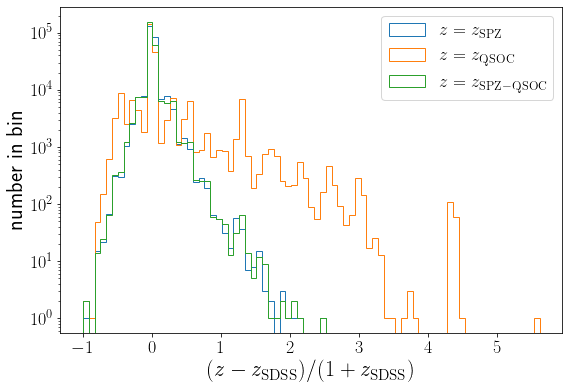

In [31]:
plt.figure(figsize=(9,6))
plt.hist(dz1pz_spz, bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz1pz_qsoc, bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.hist(dz1pz_spzqsoc, bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ-QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
plt.yscale('log')

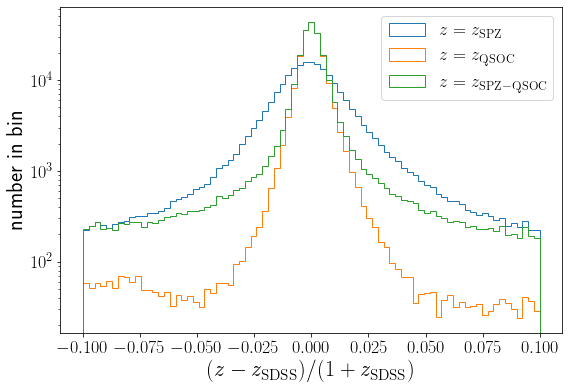

In [32]:
plt.figure(figsize=(9,6))
plt.hist(dz1pz_spz, bins=dz1pz_bins_near_zero, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz1pz_qsoc, bins=dz1pz_bins_near_zero, histtype='step', label=r'$z=z_\mathrm{QSOC}$')
plt.hist(dz1pz_spzqsoc, bins=dz1pz_bins_near_zero, histtype='step', label=r'$z=z_\mathrm{SPZ-QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
plt.yscale('log')

Bit better!

Text(0, 0.5, '$z_{SPZ/QSOC}$, spectro-photometric redshift or QSOC')

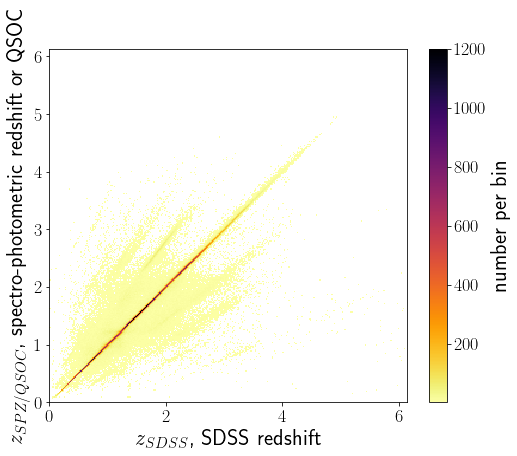

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_spzqsoc, bins=z_bins, cmin=1, cmap='inferno_r',
              vmax=1200)
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ/QSOC}$, spectro-photometric redshift or QSOC')

In [52]:
print("Number of test objects: ", len(z_sdss))
for z_thresh in z_threshs:
    frac_recovered = get_fraction_within_threshold(dz1pz_spzqsoc, z_thresh)
    frac_recovered_spz = get_fraction_within_threshold(dz1pz_spz, z_thresh)

    frac_recovered_qsoc = get_fraction_within_threshold(dz1pz_qsoc, z_thresh)
    print(rf"Fraction recovered with dz(1+z)<{z_thresh}: {frac_recovered:.3f}")
    print(rf"(QSOC: {frac_recovered_qsoc:.3f}, SPZ: {frac_recovered_spz:.3f})")

Number of test objects:  260119
Fraction recovered with dz(1+z)<0.02: 0.746
(QSOC: 0.707, SPZ: 0.631)
Fraction recovered with dz(1+z)<0.05: 0.804
(QSOC: 0.720, SPZ: 0.791)
Fraction recovered with dz(1+z)<0.1: 0.844
(QSOC: 0.727, SPZ: 0.846)
Fraction recovered with dz(1+z)<0.2: 0.911
(QSOC: 0.746, SPZ: 0.914)


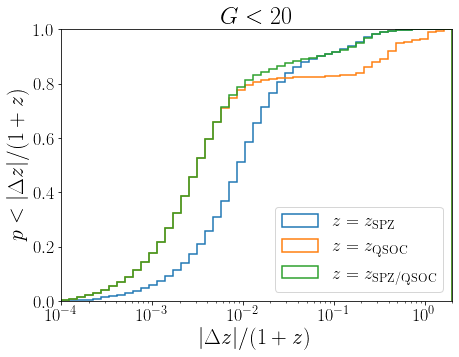

In [69]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_max}$', fontsize=24)
lw=1.5
plt.hist(abs(dz1pz_spz[idx_G]), bins=np.logspace(-4, np.log10(2), 50), 
         histtype='step', cumulative=True, density=True, lw=lw,
        label=r'$z=z_\mathrm{SPZ}$')
plt.hist(abs(dz1pz_qsoc[idx_G]), bins=np.logspace(-4, np.log10(2), 50), 
         histtype='step', cumulative=True, density=True, lw=lw,
         label=r'$z=z_\mathrm{QSOC}$')
plt.hist(abs(dz1pz_spzqsoc[idx_G]), bins=np.logspace(-4, np.log10(2), 50), 
         histtype='step', cumulative=True, density=True, lw=lw,
         label=r'$z=z_\mathrm{SPZ/QSOC}$')
plt.xlabel(r'$|\Delta z|/(1+z)$')
plt.ylabel(r'$p < |\Delta z|/(1+z)$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

Save these!

TODO

In [64]:
z_spz_all = tab_spz['redshift_spz']
z_qsoc_all = tab_spz['redshift_qsoc']

In [65]:
dz1pz_thresh = 0.1
dz1pz_qsoc_spz_all = (z_qsoc_all-z_spz_all)/(1+z_spz_all)

i_qsoc_spz_agree_all = np.abs(dz1pz_qsoc_spz_all) < dz1pz_thresh
redshift_spzqsoc = z_spz_all

redshift_spzqsoc[i_qsoc_spz_agree_all] = z_qsoc_all[i_qsoc_spz_agree_all]

In [72]:
fn_spz_wspzqsoc = f'../data/redshifts_spz_kNN_G{G_max_spz}{spz_tag}_wspzqsoc.fits'

tab_spz['redshift_spzqsoc'] = redshift_spzqsoc
tab_spz.write(fn_spz_wspzqsoc, overwrite=True)

AttributeError: 'numpy.ndarray' object has no attribute 'write'

Not sure how useful these plots are but

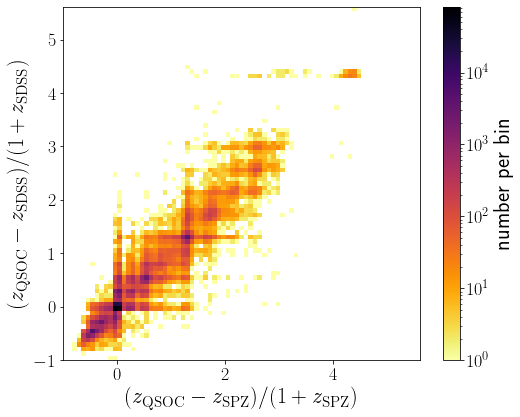

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(dz1pz_qsoc_spz, dz1pz_qsoc, 
          bins=dz1pz_bins, cmin=1, cmap='inferno_r',
          norm=matplotlib.colors.LogNorm())

plt.xlabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SPZ})/(1 + z_\mathrm{SPZ})$')
plt.ylabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')

fig.colorbar(h[3], ax=ax, label='number per bin')

Text(0, 0.5, '$(z_\\mathrm{QSOC} - z_\\mathrm{SDSS})/(1 + z_\\mathrm{SDSS})$')

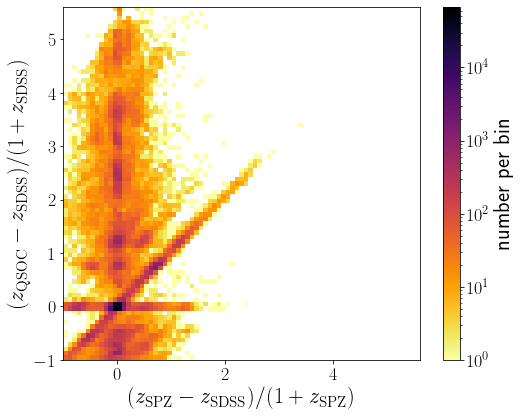

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(dz_spz, dz_qsoc, 
          bins=dz1pz_bins, cmin=1, cmap='inferno_r',
          norm=matplotlib.colors.LogNorm())

fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$(z_\mathrm{SPZ} - z_\mathrm{SDSS})/(1 + z_\mathrm{SPZ})$')
plt.ylabel(r'$(z_\mathrm{QSOC} - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')

# G-cut dependence of outliers

In [35]:
dz1pz_thresh = 0.1
G_arr = tab_spz['phot_g_mean_mag'][i_has_sdss_redshift]
G_maxs = np.linspace(17, 20.5, 30)
n_insample = np.empty(len(G_maxs), dtype=int)
f_outliers = np.empty(len(G_maxs))
for i in range(len(G_maxs)):
    i_insample = G_arr < G_maxs[i]
    n_insample[i] = np.sum(i_insample)
    f_outliers[i] = np.sum(dz1pz_spz[i_insample] > dz1pz_thresh) / n_insample[i]

(17.0, 20.5)

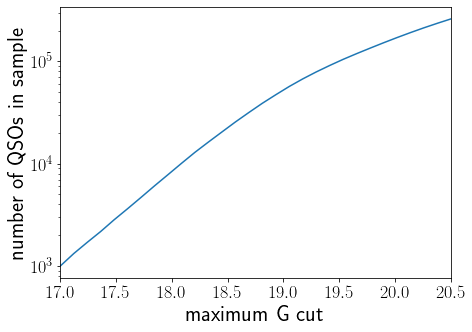

In [36]:
plt.figure(figsize=(7,5))
plt.plot(G_maxs, n_insample)
plt.xlabel("maximum G cut")
plt.ylabel(fr'number of QSOs in sample')
plt.yscale('log')
plt.xlim(np.min(G_maxs), np.max(G_maxs))

(17.0, 20.5)

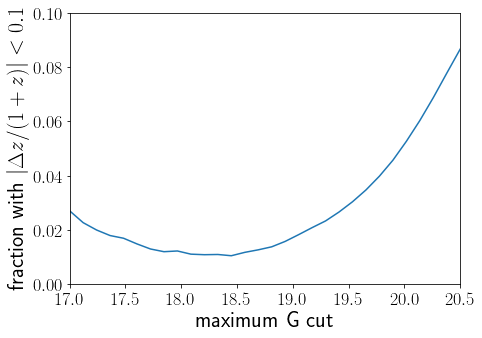

In [37]:
plt.figure(figsize=(7,5))
plt.plot(G_maxs, f_outliers)
plt.xlabel("maximum G cut")
plt.ylabel(fr'fraction with $|\Delta z/(1+z)|<{dz1pz_thresh}$')
plt.ylim(0, 0.1)
plt.xlim(np.min(G_maxs), np.max(G_maxs))